In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [5]:
caminho_arquivo = 'proton1E20_auger_tratado'
df = pl.read_csv(caminho_arquivo, has_header=False)

df = df.with_columns(pl.col("column_1").str.split(" ").alias("split_column"))
df = df.with_columns([
    pl.col("split_column").list.get(0).alias("EAS"),
    pl.col("split_column").list.get(1).cast(pl.Float64).alias("particle"),
    pl.col("split_column").list.get(2).cast(pl.Float64).alias("x_part_cm"),
    pl.col("split_column").list.get(3).cast(pl.Float64).alias("y_part_cm"),
    pl.col("split_column").list.get(4).cast(pl.Float64).alias("r_part_cm"),
    pl.col("split_column").list.get(5).cast(pl.Float64).alias("thinning")
])

df = df.filter(pl.col('EAS') == "3")
df = df.with_columns([
    (pl.col("x_part_cm") / 100).alias("x_part_m"),
    (pl.col("y_part_cm") / 100).alias("y_part_m")
])

In [6]:
# Parâmetros da grade
raio = 6500  # 6.5 km em metros
tamanho_quadrado = 4.0
min_x, max_x = -raio, raio
min_y, max_y = -raio, raio

# Calcular índices dos quadrados
df = df.with_columns([
    ((pl.col("x_part_m") - min_x) / tamanho_quadrado).floor().cast(pl.Int32).alias("idx_x"),
    ((pl.col("y_part_m") - min_y) / tamanho_quadrado).floor().cast(pl.Int32).alias("idx_y")
])

# Calcular densidade por quadrado
densidade_quadrados = df.group_by(["idx_x", "idx_y"]).agg(
    (pl.sum("thinning") / (tamanho_quadrado ** 2)).alias("densidade")
)

# Número de quadrados em x e y
n_x = int((max_x - min_x) / tamanho_quadrado)
n_y = int((max_y - min_y) / tamanho_quadrado)

# Inicializar e preencher matriz de densidade
dens_matrix = np.zeros((n_y, n_x))
for row in densidade_quadrados.iter_rows(named=True):
    i, j = row['idx_x'], row['idx_y']
    if 0 <= i < n_x and 0 <= j < n_y:
        dens_matrix[j, i] = row['densidade']  # j=linha (y), i=coluna (x)

# Arestas dos quadrados para plotagem
x_edges = min_x + np.arange(0, n_x+1) * tamanho_quadrado
y_edges = min_y + np.arange(0, n_y+1) * tamanho_quadrado


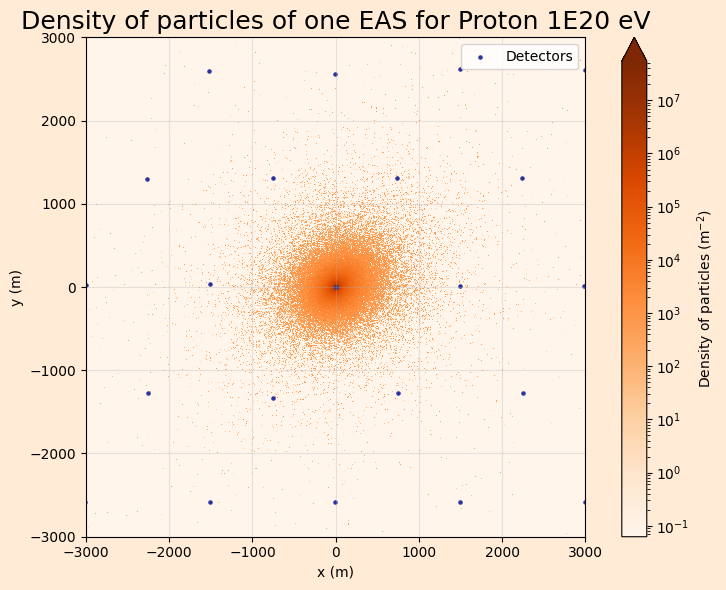

In [ ]:
# Carregar posições dos detectores
map_auger = pl.read_csv('map_auger.csv', has_header=False)
detectores = map_auger.select([
    pl.col("column_2").cast(pl.Float64).alias("x_det"),
    pl.col("column_3").cast(pl.Float64).alias("y_det")
])

# Configurar o gráfico
plt.figure(figsize=(8, 6), dpi=100, facecolor = '#FFEBD6')

# Preparar dados para escala logarítmica (evitando log(0))
plot_matrix = dens_matrix.copy()
min_non_zero = np.min(plot_matrix[plot_matrix > 0])
plot_matrix[plot_matrix == 0] = min_non_zero * 0.01  # Valor baixo para zeros

# Mapa de calor com escala logarítmica
mesh = plt.pcolormesh(
    x_edges, y_edges, plot_matrix,
    shading='auto',
    cmap='Oranges',
    norm=LogNorm(vmin=min_non_zero, vmax=np.max(plot_matrix)),
    rasterized = True
)
plt.colorbar(mesh, label='Density of particles (m$^{-2}$)', extend='max')

# Posição dos detectores (em vermelho)
detectores_coords = detectores.to_numpy()
plt.scatter(
    detectores_coords[:,0], detectores_coords[:,1],
    color='#29339B', s=5, label='Detectors'
)

# Configurações do gráfico
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Density of particles of one EAS for Proton 1E20 eV', size = 18)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Limitar área visível para melhor visualização
plt.xlim(-3000, 3000)
plt.ylim(-3000, 3000)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig('one_eas_density_proton1E20_auger.pdf', bbox_inches = 'tight', dpi = 300)
plt.show()